In [1]:
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications import resnet50
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import wget
import zipfile as zf

%matplotlib inline

/home/ubuntu/anaconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TRAIN_DIR = './train'
TEST_DIR = './test'
TRAIN_ZFILE = 'train.zip'
TEST_ZFILE = 'test.zip'

In [3]:
def may_download_or_extract(url, zfile, zdir):
    
    if not os.path.isdir(zdir):
        if not zf.is_zipfile(zfile):
            wget.download(url, zfile)
            
        with zf.ZipFile(zfile) as my_zip:
                my_zip.extractall()            

In [4]:
train_url = ''
test_url = ''

with open('data_url.txt', 'r') as f:
    train_url = f.readline()
    test_url = f.readline()

may_download_or_extract(train_url, TRAIN_ZFILE, TRAIN_DIR)
may_download_or_extract(test_url, TEST_ZFILE, TEST_DIR)

In [5]:
def load_train_images(imgs_dir):
    
    img_names = np.array(os.listdir(imgs_dir))
    n_imgs = len(img_names)
    
    x_299 = np.zeros((n_imgs, 299, 299, 3), dtype=np.uint8)
    x_224 = np.zeros((n_imgs, 224, 224, 3), dtype=np.uint8)
    y = np.zeros((n_imgs,), dtype=np.bool)
    
    # shuffle the images    
    indices = np.arange(len(img_names))
    np.random.shuffle(indices)
    img_names = img_names[indices]
    
    for i, img_name in tqdm(enumerate(img_names)):
        img = cv2.imread(os.path.join(imgs_dir, img_name))
        x_299[i] = cv2.resize(img, dsize=(299, 299))
        x_224[i] = cv2.resize(img, dsize=(224, 224))
        if img_name.startswith('cat'):
            y[i] = False
        else:
            y[i] = True
    
    return x_299, x_224, y

In [6]:
def load_test_images(imgs_dir):
    
    img_names = np.array(os.listdir(imgs_dir))
    n_imgs = len(img_names)
    
    ids = np.zeros((n_imgs,), dtype='<U6')
    x_299 = np.zeros((n_imgs, 299, 299, 3), dtype=np.uint8)
    x_224 = np.zeros((n_imgs, 224, 224, 3), dtype=np.uint8)
    
    for i, img_name in tqdm(enumerate(img_names)):
        img = cv2.imread(os.path.join(imgs_dir, img_name))
        x_299[i] = cv2.resize(img, dsize=(299, 299))
        x_224[i] = cv2.resize(img, dsize=(224, 224))
        ids[i] = img_name[:-4]
    
    return ids, x_299, x_224

In [7]:
def preprocess_input(x):
    
    x = x.astype(np.float32)
    x /= 127.5
    x -= 1.
    
    return x

In [8]:
#示例图片
def show_img_examples(x, y):    
    
    inds = np.random.randint(len(y),size=12)
    x_examples = x[inds]
    y_examples = y[inds]
    fig = plt.figure(figsize=(20,8))
    
    for i, (img, cls) in enumerate(zip(x_examples, y_examples)):
        a = fig.add_subplot(2, 6, i+1)
        plt.imshow(img)
        a.set_title('dog {:.2f}%'.format(cls*100) if cls>0.5 else 'cat {:.2f}%'.format((1-cls)*100))
    
    plt.show()

In [9]:
def my_datagen(x1, x2, y, batch_size=32, train=True):
    if train:
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator()
        
    gen1 = datagen.flow(x1, batch_size=batch_size, seed=0, shuffle=train)
    gen2 = datagen.flow(x2, y, batch_size=batch_size, seed=0, shuffle=train)
    
    while True:
        x_1 = next(gen1)
        x_2, y_ = next(gen2)
        yield [x_1, x_2], y_

In [10]:
def my_model(lr):
    
    input_1 = Input(shape=(299, 299, 3))
    input_2 = Input(shape=(224, 224, 3))
        
    base_model_1 = Xception(input_tensor=input_1, include_top=False, weights='imagenet')
    base_model_2 = InceptionV3(input_tensor=input_1, include_top=False, weights='imagenet')
    base_model_3 = resnet50.ResNet50(input_tensor=input_2, include_top=False, weights='imagenet')
        
    x1 = base_model_1.output
    x2 = base_model_2.output
    x3 = base_model_3.output
    
    x1 = GlobalAveragePooling2D()(x1)
    x2 = GlobalAveragePooling2D()(x2)
    x3 = GlobalAveragePooling2D()(x3)
    
    x = Concatenate(axis=-1)([x1, x2, x3])
        
    x = Dense(1024, activation='relu', kernel_initializer='truncated_normal', kernel_regularizer=l2(0.0001))(x)
    x = Dropout(0.5)(x)
        
    preds = Dense(1, activation='sigmoid', kernel_initializer='truncated_normal', kernel_regularizer=l2(0.0001))(x)
    
    # this is the model we will train
    model = Model(inputs=[input_1, input_2], outputs=preds)
        
    # freeze all base model layers
    for layer in base_model_1.layers:
        layer.trainable = False
        
    for layer in base_model_2.layers:
        layer.trainable = False
        
    for layer in base_model_3.layers:
        layer.trainable = False
        
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
x_train_299, x_train_224, y_train = load_train_images(TRAIN_DIR)

25000it [01:07, 371.03it/s]


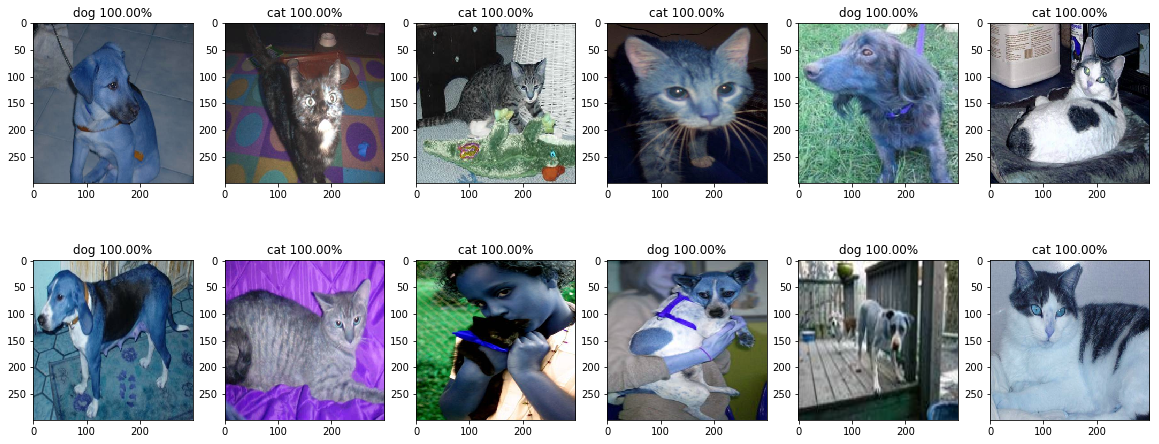

In [12]:
show_img_examples(x_train_299, y_train)

In [13]:
x_train_1 = preprocess_input(x_train_299)
x_train_2 = resnet50.preprocess_input(x_train_224.astype(np.float32))

train_gen = my_datagen(x_train_1[:20000], x_train_2[:20000], y_train[:20000], batch_size=128)
val_gen = my_datagen(x_train_1[20000:], x_train_2[20000:], y_train[20000:], batch_size=128, train=False)

In [14]:
model = my_model(0.0001)
#model.summary()

In [15]:
# training
hist = model.fit_generator(
    train_gen,
    steps_per_epoch=157,
    epochs=10,
    validation_data=val_gen,
    validation_steps=40)

model.save('my_model.h5')

Epoch 1/10
157/157 [==============================] - 672s 4s/step - loss: 1.3216 - acc: 0.9489 - val_loss: 1.2102 - val_acc: 0.9852
Epoch 2/10
157/157 [==============================] - 633s 4s/step - loss: 1.1936 - acc: 0.9769 - val_loss: 1.1636 - val_acc: 0.9808
Epoch 3/10
157/157 [==============================] - 633s 4s/step - loss: 1.1289 - acc: 0.9797 - val_loss: 1.0755 - val_acc: 0.9896
Epoch 4/10
157/157 [==============================] - 633s 4s/step - loss: 1.0674 - acc: 0.9817 - val_loss: 1.0340 - val_acc: 0.9874
Epoch 5/10
157/157 [==============================] - 633s 4s/step - loss: 1.0105 - acc: 0.9835 - val_loss: 0.9795 - val_acc: 0.9886
Epoch 6/10
157/157 [==============================] - 634s 4s/step - loss: 0.9546 - acc: 0.9853 - val_loss: 0.9484 - val_acc: 0.9842
Epoch 7/10
157/157 [==============================] - 634s 4s/step - loss: 0.9081 - acc: 0.9867 - val_loss: 0.8765 - val_acc: 0.9930
Epoch 8/10
157/157 [==============================] - 633s 4s/step - 

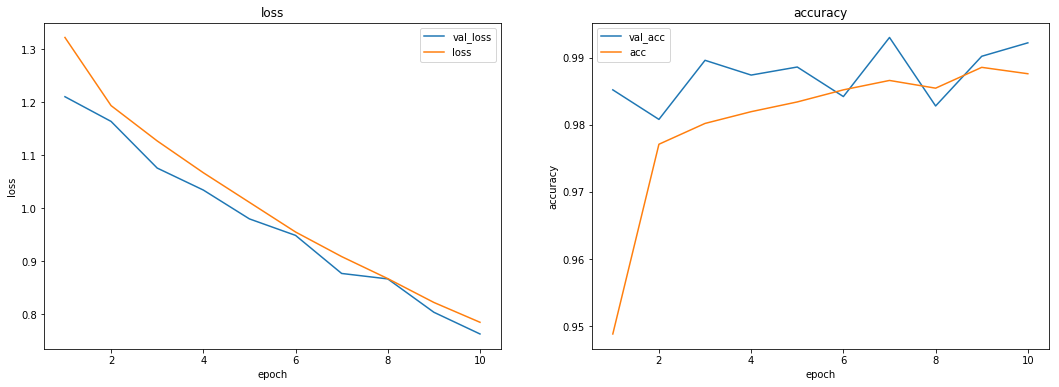

In [16]:
his = hist.history
epochs = list(range(1, 11))
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.title('loss')
plt.plot(epochs, his['val_loss'], label='val_loss')
plt.plot(epochs, his['loss'], label='loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(122)
plt.title('accuracy')
plt.plot(epochs, his['val_acc'], label='val_acc')
plt.plot(epochs, his['acc'], label='acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [10]:
from keras.models import load_model
model = load_model('my_model.h5')

ids, x_test_299, x_test_224 = load_test_images(TEST_DIR)
x_test_1 = preprocess_input(x_test_299)
x_test_2 = resnet50.preprocess_input(x_test_224.astype(np.float32))

preds = model.predict([x_test_1, x_test_2], batch_size=64)

12500it [00:34, 360.82it/s]


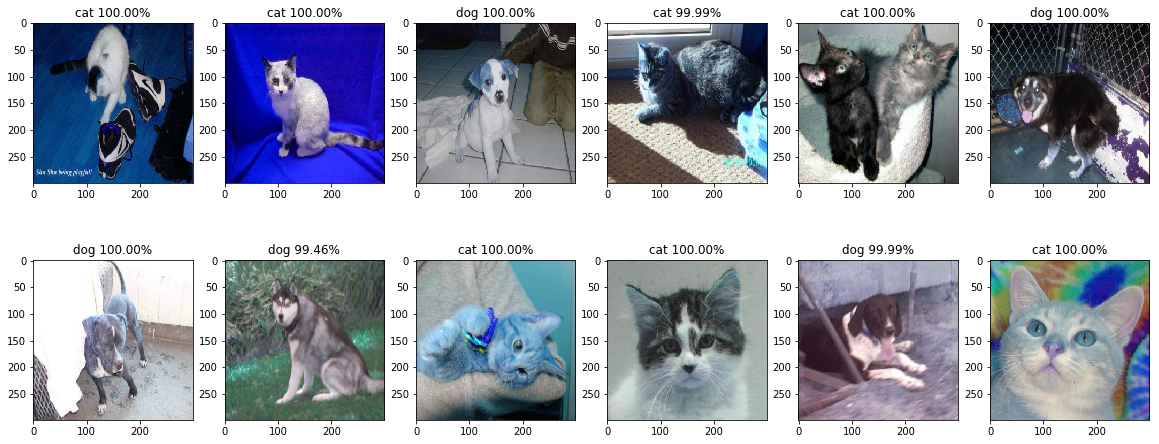

In [11]:
show_img_examples(x_test_299, preds[:,0])

In [12]:
# save predictions as a csv file
import pandas as pd
dic = {'id':ids, 'label':preds[:,0].clip(min=0.002, max=0.998)}
df = pd.DataFrame(dic)
df.to_csv('submission.csv', index=False)

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [14]:
m1 = Model(inputs=model.input, outputs=model.get_layer('block14_sepconv2_act').output)
m2 = Model(inputs=model.input, outputs=model.get_layer('mixed10').output)
m3 = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

weight1 = model.get_layer('dense_1').get_weights()[0]
weight2 = model.get_layer('dense_2').get_weights()[0]

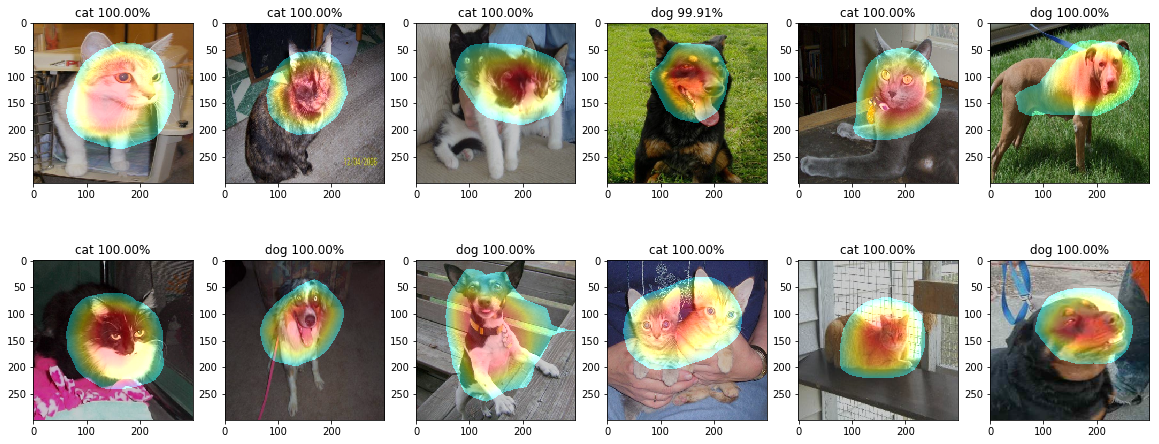

In [17]:
inds = np.random.randint(len(x_test_299),size=12)
x_ori_examples = x_test_299[inds]
x_examples_1 = x_test_1[inds]
x_examples_2 = x_test_2[inds]
y_examples = preds[:,0][inds]

preds_m1 = m1.predict([x_examples_1, x_examples_2])
preds_m2 = m2.predict([x_examples_1, x_examples_2])
preds_m3 = m3.predict([x_examples_1, x_examples_2])

cams1 = np.matmul(np.matmul(preds_m1, weight1[:2048]), weight2)
cams2 = np.matmul(np.matmul(preds_m2, weight1[2048:4096]), weight2)
cams3 = np.matmul(np.matmul(preds_m3, weight1[4096:]), weight2)

fig = plt.figure(figsize=(20,8))

for i, (img, cam1, cam2, cam3, cls) in enumerate(zip(x_ori_examples, cams1, cams2, cams3, y_examples)):
    
    a = fig.add_subplot(2, 6, i+1)
    
    cam1 = cv2.resize((cls-0.5)*cam1, dsize=(299, 299))
    cam2 = cv2.resize((cls-0.5)*cam2, dsize=(299, 299))
    cam3 = cv2.resize((cls-0.5)*cam3, dsize=(299, 299))
    cam = cam1 + cam2 + cam3
    
    cam = (cam - cam.min()) / (cam.max() - cam.min()) * 255
    cam = cam.astype(np.uint8)
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    heatmap[cam < 96] = 0
    
    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
        
    a.set_title('dog {:.2f}%'.format(cls*100) if cls>0.5 else 'cat {:.2f}%'.format((1-cls)*100))
    plt.imshow(out[:,:,::-1])

plt.show()